In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cycler import cycler
import seaborn
import pickle
from matplotlib import cm
from scipy.interpolate import griddata
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}")

## Compatibility

To reproduce the results presented in [[1]](#References), The `Comphy` tags of Kratos and ROM_AM should be installed. Using later/other versions can induce errors.

Previously trained ROMs are stored in the form of `.pkl` files in the `./trainedROMs` folder.
Those ROMs are constructed as described in this notebook, using MacOs 12.6 (arm64), Apple Clang 13.0.0 and Python 3.11. The `numpy` version is `1.24.3`.


# FSI Configuration

This first example models a flow inside an elastic tube. The flow is assumed to be incompressible with constant density $\rho$. Both fluid mass and momentum conservation equations (neglecting viscosity) read

\begin{equation}
    \begin{cases}
	 \partial_t a + \partial_x(a v) = 0, \\
        \partial_t(av)+ \partial_x(a v^2) + \dfrac{a}{\rho}\,\partial_x p = 0,
	\quad t>0, \ x\in [0,L]
 \end{cases}\tag{1}
\end{equation}

where $v$ is the velocity, $a$ is the time-dependent tube cross section and
$p$ is the pressure. From the fluid side, the unknowns are both
velocity and pressure.
For the thin flexible tube with a thickness $h_s$, a quasi-static model 
\begin{equation}
     {p} \sqrt{\frac{{a}}{\pi}} =  \sigma_{\varphi \varphi}(a) h_s\tag{2}
\end{equation}

is used (retaining only the vessel stress in the circumferential direction). The following nonlinear elastic stress-strain law:
\begin{equation}
    \begin{cases}
	 \sigma_{\varphi \varphi} = E\, \epsilon_{\varphi \varphi}\quad \text{if} \ |\epsilon_{\varphi \varphi}|< \epsilon_0 \\
   \sigma_{\varphi \varphi} = E/\alpha\, \epsilon_{\varphi \varphi} + 20\quad \text{if} \ \epsilon_{\varphi \varphi}\geq \epsilon_0 \\
   \sigma_{\varphi \varphi} = E/\alpha\, \epsilon_{\varphi \varphi} - 20\quad \text{if} \ \epsilon_{\varphi \varphi}\leq -\epsilon_0 \\
 \end{cases}
\end{equation}
with $\alpha=5$, $\epsilon_0=2\,\, 10^{-3}$ and $E=12500~Pa$. We take $L=10$, $\rho = 1$ and $h_s = 1$ in adimensional units.

An inlet velocity is imposed at the left end, and a non-reflecting boundary condition is imposed at the right boundary. 
The fluid flow equations ([1](#mjx-eqn-eq1)) are solved using a second order finite volume scheme with $100$ cells and the solid section $\pmb{a}(\pmb{p})$ is computed at each iteration as the solution of the scalar minimization problem ([2](#mjx-eqn-eq2)). The time step is $dt=0.1~s$.

More details on the 1D elastic tube problem can be found in [[1, 2, 3]](#References).

**Parametrization**: The considered parameter here will be the frequencies composing the inlet velocity dynamics.

The prescribed inlet ($x=0$) velocity $v_0$ is computed using the solution of a nonlinear Duffing equation in order to evaluate the ROM performances in problems with complex dynamics, and the capacity to benefit from the HF fluid solver output to handle the dynamics:
\begin{equation}
    \begin{cases}
	 \ddot u(t) = a\, u(t) + b\, u(t)^2 + c\, u(t)^3 + d + p\,cos(f t) + e\, \dot u(t)\,\,\,\, \forall t \in [0, 120] \\
   u(0) = 10\,\,\,;\,\,\,\dot u (0) = 0. \\
   v_{0}(t) = (g u(t) + h) r(t) \\
   r(t) = 1\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \forall t \in [0, 20] \\
   r(t) = 0.9+0.1 sin(t \pi / 40)\,\,\,\,\,\,\,\,\, \forall t \in [20, 60] ,\,\,\,\,\,\, {\#Negative \,\, ramp\,\, function}\\
   r(t) = 0.8\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \forall t \in [60, 120]  . \\
 \end{cases}
\end{equation}
We fix $(a,\ b\ ,c\ ,d\ ,e\ ,g\ , p) = (-1,0 ,-0.002 ,-1 ,-0.02 ,1/60,360)$ and we parameterize this signal with the parameter vector $\pmb{\mu} =(f\,\,\, ,h )^T$ allowing the generation of different frequencies and amplitudes. For this study, the two values $\pmb{\mu}_1 = [2,\, 6]^T$ and $\pmb{\mu}_2 = [0.9,\, 4]^T$ have been selected, leading to the signals shown here.

In accordance with the ROM architecture, the pressure field represents the interface force field, adn the section field replaces the displacement field.

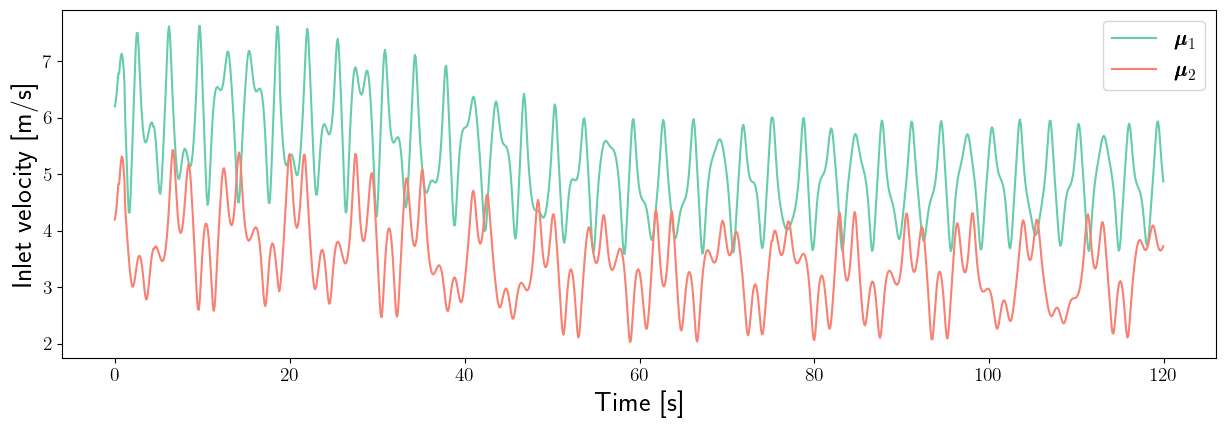

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}")

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(np.arange(0.0, 120., 0.1), np.load("./data/FOM//velocity.npy")[0, :], color = 'mediumaquamarine', label = r'$\pmb{\mu}_1$');
plt.plot(np.arange(0.0, 120., 0.1), np.load("./results/FOM_mu2/velocity.npy")[0, :], color = 'salmon',label = '$\pmb\mu_2$');
plt.tight_layout();
ax.set_ylabel('Inlet velocity [m/s]', fontsize=20)
ax.set_xlabel('Time [s]', fontsize=20)
plt.legend(fontsize = 16);
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

# Making the Reduced Order Models

![imgg](../../figs/CoupledClasses.png)

Data corresponding to the elastic tube simulation with $\pmb{\mu}_1 = [2,\, 6]^T$ was stored in the form of numpy arrays in the `data/` folder. The simulation snapshots of pressure, velocity and section area are store, as well as the number of iterations per time step. Note that the data also contains the output of the intermediate subiterations, and not just the converged results.

In [3]:
# Loading the data as numpy arrays
iters = np.load("./data/FOM/iters.npy") # Number of iterations/per time step
pressure = np.load("./data/FOM/solidPres.npy") # Snapshots of 1D pressure field
sect = np.load("./data/FOM/solidSect.npy") # Snapshots of 1D section area field

Training data will include the snapshots up to $t=3.5~s$, *i.e* 350 time steps.

In [4]:
tr_load_data = pressure[:, np.cumsum(iters[:350])-1]
tr_sect_data = sect[:, np.cumsum(iters[:350])-1]

## Solid ROMs

The solid ROM can be constructed and trained using the `solid_ROM` class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Quadratic manifolds for the displacement field reduction $r_u = 4$ retaining $99.99%$ of the energy.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;POD for load field reduction the $r_f = 10$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RBF interpolation with thin plate spline kernel functions as the regression model.

In [5]:
from rom_am.solid_rom import solid_ROM

sol_rom = solid_ROM()
sol_rom.train(tr_load_data,
              tr_sect_data,
              forcesReduc_model="POD", rank_pres=10,
              dispReduc_model="QUAD", rank_disp=.9999,
              regression_model="RBF", norm_regr=[False, True])


/Users/azzeddinetiba/opt/anaconda3/lib/python3.9/site-packages/rom_am/solid_rom.py:138: FutureWarning: `to_copy` parameter will be removed Copying the snapshots informations will be avoided for memory savingsTo use the future default and silence this warning we advise to pass `to_copy=[False, False]`. 
  warnings.warn("`to_copy` parameter will be removed "


## Fluid ROMs

The fluid ROM can be constructed and trained using the `FluidSurrog` class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_f = 10$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The solid `RomDimensionalityReducer` accessed through `sol_rom.dispReduc_model` is passed as an argument for the fluid ROM.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RBF interpolation with thin plate spline kernel functions as the regression model.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Retraining of the regressor is done after each $Z = 200$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The constant size of training batch is $p = 1638$.

In [6]:
dispData = np.load("./data/FOM/solidSect.npy")
AccelloadData = np.load("./data/FOM/solidPres.npy")
flLoadData = np.load("./data/FOM/fluidPres.npy")
lastIters = iters.cumsum()-1
flLoadDataConv = AccelloadData[:, lastIters]
flLoadDataConv0 = flLoadDataConv[:, :-1]
RepflLoadDataConv0 = np.repeat(flLoadDataConv0, iters[1:], axis = 1)
lastId = iters[:350].cumsum()[-1]
trainIds = np.arange(0, lastId, 1)
testIds = np.arange(lastId, iters.cumsum()[-1], 1)

trainflLoadData = flLoadData[:, trainIds][:, iters[0]:]
traindispInterf = dispData[:, trainIds][:, iters[0]:]

In [7]:
from rom_am.fluid_surrogate import FluidSurrog

fldSurr = FluidSurrog(maxLen = 1638, reTrainThres = 200)
fldSurr.train(traindispInterf, RepflLoadDataConv0[:, :trainflLoadData.shape[1]], trainflLoadData,
              rank_pres=10,
              kernel = 'thin_plate_spline', smoothing=0., degree=1,
              solidReduc=sol_rom.dispReduc_model,
              norm=[False, False], center=[True, True])


 ----- Load Reduction -----
 ----- Displacement Reduction -----
 ----- Regression -----


The ROMs can be saved with `sol_rom.save("./trainedROMs/solidROM")` and `fldSurr.save("./trainedROMs/fluidSurrog")`, and then can be loaded for the simulation by indicating the object files in the [`./cosim_fsi_parameters.json`](./cosim_fsi_parameters.json) file.

# Simulation settings

The solid model parameters are defined in [`./fsi_par/solidParams.json`](./fsi_par/solidParams.json). The fluid model parameters in [`./fsi_par/fluidParams.json`](./fsi_par/fluidParams.json) .

The coupling settings can be set in the [`./cosim_fsi_parameters.json`](./cosim_fsi_parameters.json) file.

<table>
<tr>
<th>Coupling parameter</th>
<th>Parameter choice</th>
<th>Associated hypermarameters</th>
</tr>
<tr>
<td>Coupling formulation</td>
<td>Accelerated Gauß-Seidel  $\mathcal{F}(\mathcal{S}(\boldsymbol{f})) = \boldsymbol{f}$</td>
<td>Tolerance $\epsilon = 10^{-4}$</td>
</tr>
<tr>
<td>Convergence acceleration</td>
<td>IQN-ILS</td>
<td>$d=40$, $q=2$, $w_0=0.4$</td>
</tr>
<tr>
<td>Predictors</td>
<td>Constant *vs* Linear *vs* Quadratic *vs* Data-Driven</td>
<td>Tolerance $\epsilon_r = 2.10^{-2}$, $w_0=0.04$</td>
</tr>
</table>

The simulation results are saved in the `./coSimData/` folder.

# Post-processing

The results of the pressure field, section area field, velocity field and number of iterations are stored in the `results/` folder.

**To reproduce those results**, a `README` file inside each `results/` subfolder shows the `json`settings to be modified.

In [8]:
"""
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as manimation
from tubePlotting import doPlotting
import numpy as np
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 2, width_ratios = [0.95, 0.03], height_ratios = [0.95, 0.03])
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])
cbar_ax2 = fig.add_subplot(gs[2])

endT = 1200

FFMpegWriter = manimation.writers['imagemagick']
metadata = dict(title='PulseTube')
writer = FFMpegWriter(fps=15, metadata=metadata)
writer.setup(fig, "writer_test.mp4", 100)

maxV = np.load("./FOM_LinearPred/velocity.npy")[:, :endT].max()
minV = np.load("./FOM_LinearPred/velocity.npy")[:, :endT].min()

strsMax = (np.load("./FOM_LinearPred/pressure.npy")*np.sqrt(np.load("./FOM_LinearPred/section.npy")/np.pi))[:, :endT].max()
strsMin = (np.load("./FOM_LinearPred/pressure.npy")*np.sqrt(np.load("./FOM_LinearPred/section.npy")/np.pi))[:, :endT].min()
for i in range(endT):
    cmaps = doPlotting(ax, np.load("./FOM_LinearPred/section.npy")[:, i], np.load("./FOM_LinearPred/velocity.npy")[:, i],
               np.load("./FOM_LinearPred/pressure.npy")[:, i], 10/100, (i+1)*0.1, minV, maxV, strsMin, strsMax)

    vBar = cm.ScalarMappable(cmap = 'RdYlBu')
    vBar.set_clim(vmin = minV, vmax = maxV)
    strsBar = cm.ScalarMappable()
    strsBar.set_clim(vmin = strsMin, vmax = strsMax)

    cbar = fig.colorbar(strsBar, cax = cbar_ax)
    cbar2 = fig.colorbar(vBar, cax = cbar_ax2, orientation='horizontal')

    writer.grab_frame()
    ax.cla()
    cbar_ax.set_title("Stress")
    cbar_ax2.set_title("Velocity")


writer.finish()
""";

![anim](./figs/flexibletube.gif)

## ROM-FOM results

We show the tube outlet section area in function of time, when comparing the FOM-FOM solution to the ROM-FOM solution, with the unseen $\pmb{\mu}_1 = [0.9,\, 4]^T$. It is thus a time-parameter prediction since the model was trained on $\pmb{\mu}_1 = [2,\, 6]^T$ and $t<=35s$.


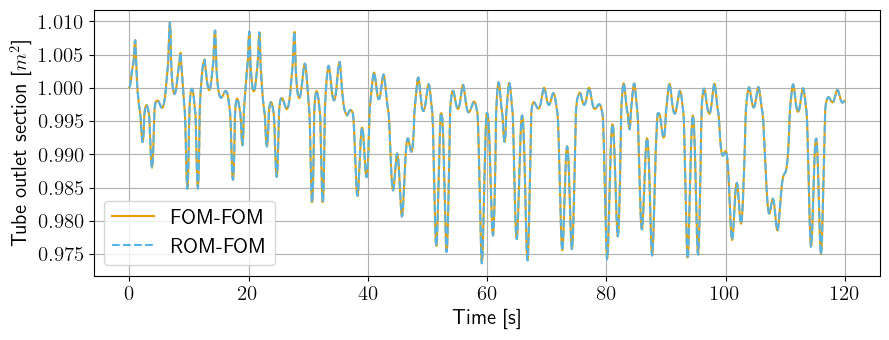

In [9]:
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "-","-","-","-","-","-",
                                   #"--", "-.", ":", "-", "--", "-."
                                  ],
                       marker=["", "^", "v", ".", "", "", ""],
                       markevery=[80, 80, 80, 80, 80, 80, 80]))

fig, ax = plt.subplots(figsize = (9, 3.5))
ax.set_prop_cycle(line_cycler)
plt.plot(np.arange(0., 120., 0.1), np.load("./results/FOM_mu2/section.npy")[-1, :], '-', label = 'FOM-FOM');
plt.plot(np.arange(0., 120., 0.1), np.load("./results/ROM_mu2_SurrPrediction/section.npy")[-1, :], '--', label = 'ROM-FOM');
plt.grid();
plt.legend(fontsize = 15);
plt.xlabel("Time [s]", fontsize = 15);
plt.ylabel(r"Tube outlet section [$m^2$]", fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.tight_layout();
#plt.savefig("case1_prediction.pdf", bbox_inches='tight');

High accuracy can be seen for the section evolution prediction, sicne the presence of the high-fidelity FOM on the fluid side gives a corrective feature for the dynamics predictions. As long as the amplitudes of the pressure field are not very far from those seen in training, it is expected to have accurate ROM predictions even for complex dynamics and time-parameter (modereate) extraploation regions.

------------------------------------------------------------------------------------------------------------------------


The nonlinearity of the model can be seen in the reconstruction of the stress-strain elastic tube law.

We recall that $\sigma_{\varphi, \varphi} = p r$ and $\epsilon_{\varphi, \varphi} = \frac{r - r_0}{r0}$.

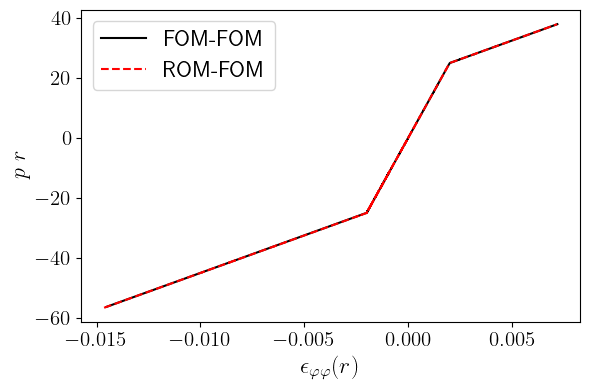

In [10]:
fig, ax = plt.subplots(figsize = (6, 4))
r0 = 1/np.sqrt(np.pi)
secFOM = np.load("./results/FOM_mu2/section.npy")[:, :]
epsFOM = ( np.sqrt(secFOM/np.pi) - r0 )/(r0)
strsFOM = np.load("./results/FOM_mu2/pressure.npy")[:, :]*np.sqrt(secFOM/np.pi)

secFOM2 = np.load("./results/ROM_mu2_SurrPrediction/section.npy")[:, :]
epsFOM2 = ( np.sqrt(secFOM2/np.pi) - r0 )/(r0)
strsFOM2 = np.load("./results/ROM_mu2_SurrPrediction/pressure.npy")[:, :]*np.sqrt(secFOM2/np.pi)

idsSorted1 = np.argsort(epsFOM.ravel())
idsSorted2 = np.argsort(epsFOM2.ravel())

plt.plot(epsFOM.ravel()[idsSorted1], strsFOM.ravel()[idsSorted1], '-', color = 'k', label = 'FOM-FOM');
plt.plot(epsFOM2.ravel()[idsSorted2], strsFOM2.ravel()[idsSorted2], '--', color = 'red', label = 'ROM-FOM');

plt.xlabel(r"$\epsilon_{\varphi \varphi}(r)$", fontsize = 17);
plt.ylabel(r"$p ~r$", fontsize = 16);

plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.tight_layout();
plt.legend(fontsize = 16);
#plt.savefig("case1_solidLaw.pdf", bbox_inches='tight');

We can also visualize below the pressure-section relationship in the latent space, considering some of the reduced coordinates.
The regressor of the solid ROM approximates this relationship with an RBF function.

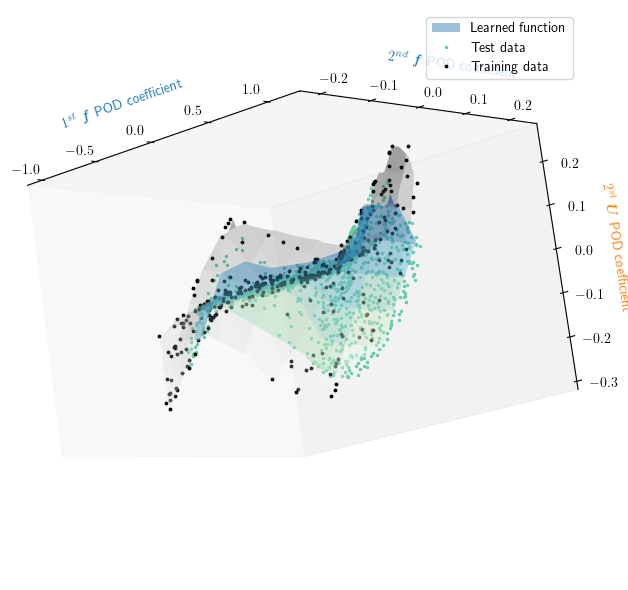

In [11]:
with open("./trainedROMs/solidROM.pkl", 'rb') as inp:
    sol = pickle.load(inp)

iters = np.load("./results/ROM_mu2/iters.npy")
coeffsIn = sol.forcesReduc.encode(np.load("./results/ROM_mu2/fluidPres.npy"))
coeffOut = sol.dispReduc_model.encode(np.load("./results/ROM_mu2/solidSect.npy"))
strsTest = np.linalg.norm(np.load("./results/ROM_mu2/fluidPres.npy") * np.sqrt(
    np.load("./results/ROM_mu2/solidSect.npy")/np.pi), axis = 0)[np.cumsum(iters)-1]

coeffsInData = sol.forcesReduc.pod.pod_coeff
coeffOutData = sol.dispReduc_model.pod.pod_coeff

#%matplotlib widget
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}")

coeffOutId = 1
coeffOutSuff = "st" if coeffOutId==1 else "nd" if coeffOutId==2 else "rd" if coeffOutId==3 else "th"
coeffOutIdname = "$"+str(coeffOutId+1)+"^{"+coeffOutSuff+"}$"

ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')

X = np.arange(np.min(coeffsInData[0,  :]),
              np.max(coeffsInData[0,  :]), 0.02)
Y = np.arange(np.min(coeffsInData[1,  :]),
              np.max(coeffsInData[1,  :]), 0.004)
X, Y = np.meshgrid(X, Y)
grid_z0 = griddata(coeffsInData[[0, 1], :].T,
                   coeffOutData[coeffOutId, :], (X, Y), method='linear')


X2 = np.arange(np.min(coeffsIn[0,  np.cumsum(iters)-1]),
               np.max(coeffsIn[0,  np.cumsum(iters)-1]), 0.1)
Y2 = np.arange( np.min(coeffsIn[1,  np.cumsum(iters)-1]),
               np.max(coeffsIn[1,  np.cumsum(iters)-1]), 0.004)
X2, Y2 = np.meshgrid(X2, Y2)
grid_z1 = griddata(coeffsIn[[0, 1], :][:, np.cumsum(iters)-1].T,
                   coeffOut[coeffOutId, np.cumsum(iters)-1],
                   (X2, Y2), method='linear')
learnTfunction = sol.regressor.regr_model(
    coeffsIn.T)[:, coeffOutId]

ax.plot_surface(X, Y, grid_z0, lw=0.5, rstride=8, cstride=8,
                alpha=0.2, cmap=cm.Greys
            #edgecolor='Grey',
               );
ax.plot_surface(X2, Y2, grid_z1, lw=0.5, rstride=8, cstride=8,
                alpha=0.4, cmap=cm.GnBu,
               #edgecolor='cyan'
                label = 'Learned function'
               );

ax.plot(coeffsIn[0, np.cumsum(iters)-1], coeffsIn[1,np.cumsum(iters)-1],
        coeffOut[coeffOutId, np.cumsum(iters)-1],
        '.', color = 'mediumaquamarine', markersize=3, label='Test data');
ax.plot(coeffsInData[0, :], coeffsInData[1, :], coeffOutData[coeffOutId, :],
        '.', markersize=3.5, color = 'black', label = 'Training data',);

ax.set_xlabel(r"$1^{st}$ $\boldsymbol{f}$ POD coefficient", color = '#1f77b4');
ax.set_ylabel(r"$2^{nd}$ $\boldsymbol{f}$ POD coefficient", color = '#1f77b4');
ax.set_zlabel(coeffOutIdname+" $\\boldsymbol{U}$ POD coefficient", color = '#ff7f0e');

plt.legend();
ax.view_init(elev=-10, azim=-50, roll=8)
plt.tight_layout();

# Hide grid lines
ax.grid(False)
ax.dist = 0

## Iteration results

We can show the accumulated number of iterations along the simulation time, comparing the efficacy of the classical predictors and the new data-driven predictor.

First, the case of $\pmb{\mu}_1 = [2,\, 6]^T$. (The predictors are "activated" at `t=35s` for a fair comparison)

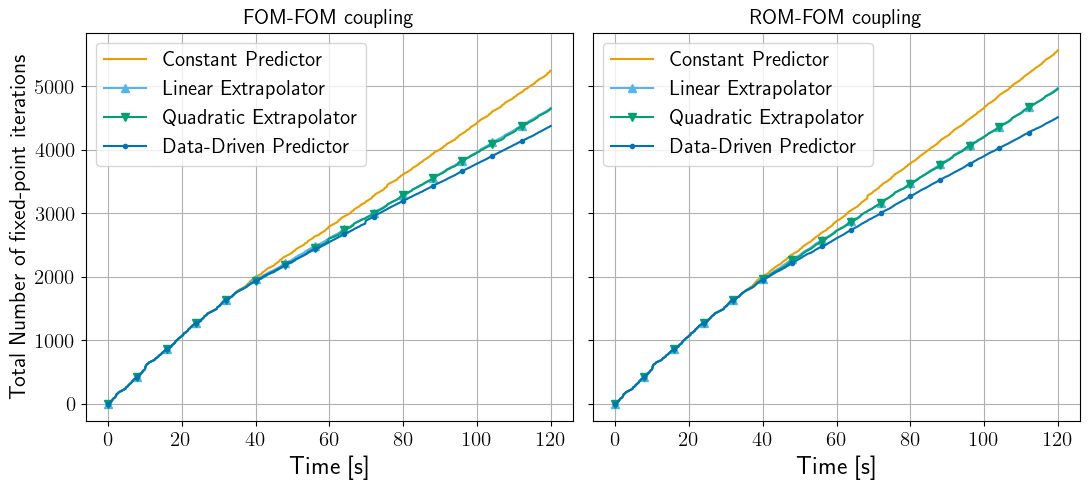

In [12]:
%matplotlib inline
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "-","-","-","-","-","-",
                                   #"--", "-.", ":", "-", "--", "-."
                                  ],
                       marker=["", "^", "v", ".", "", "", ""],
                       markevery=[80, 80, 80, 80, 80, 80, 80]))

fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
ax[0].set_prop_cycle(line_cycler)
ax[1].set_prop_cycle(line_cycler)
time_ = np.arange(0.0, 120., 0.1)


ax[1].set_title("ROM-FOM coupling", fontsize = 15);
ax[1].plot(time_, np.cumsum(np.load("./results/ROM/iters.npy")), label='Constant Predictor');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM_LinearPred/iters.npy")), label='Linear Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM_QuadPrediction/iters.npy")), label='Quadratic Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM_SurrPrediction/iters.npy")), label='Data-Driven Predictor');

ax[0].set_title("FOM-FOM coupling", fontsize = 15);
ax[0].plot(time_, np.cumsum(np.load("./data/FOM/iters.npy")), label='Constant Predictor');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM_LinearPred/iters.npy")), label='Linear Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM_QuadPrediction/iters.npy")), label='Quadratic Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM_SurrPrediction/iters.npy")), label='Data-Driven Predictor');


ax[0].set_ylabel("Total Number of fixed-point iterations", fontsize = 16);
ax[0].set_xlabel("Time [s]", fontsize = 18);
ax[1].set_xlabel("Time [s]", fontsize = 18);
ax[0].legend(fontsize = 15);
ax[1].legend(fontsize = 15);
for tick in ax[0].xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label1.set_fontsize(15)

ax[0].grid();
ax[1].grid();

plt.tight_layout();
#plt.savefig("case1_iterations_mu1.pdf", bbox_inches='tight');

And the case of $\pmb{\mu}_1 = [0.9,\, 4]^T$:

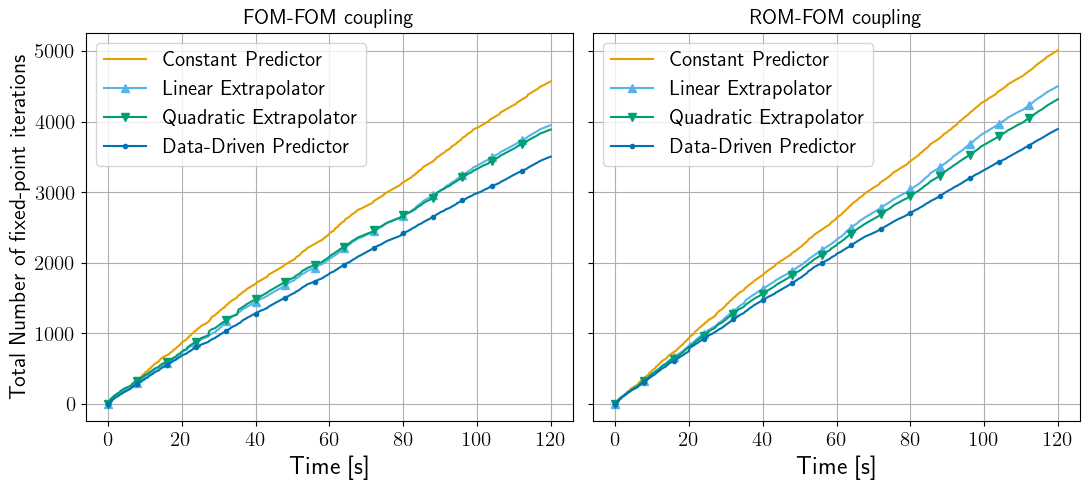

In [13]:
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "-","-","-","-","-","-",
                                   #"--", "-.", ":", "-", "--", "-."
                                  ],
                       marker=["", "^", "v", ".", "", "", ""],
                       markevery=[80, 80, 80, 80, 80, 80, 80]))

fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
ax[0].set_prop_cycle(line_cycler)
ax[1].set_prop_cycle(line_cycler)
time_ = np.arange(0.0, 120., 0.1)


ax[1].set_title("ROM-FOM coupling", fontsize = 15);
ax[1].plot(time_, np.cumsum(np.load("./results/ROM_mu2/iters.npy")), label='Constant Predictor');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM_mu2_LinearPred/iters.npy")), label='Linear Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM_mu2_QuadPrediction//iters.npy")), label='Quadratic Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM_mu2_SurrPrediction/iters.npy")), label='Data-Driven Predictor');

ax[0].set_title("FOM-FOM coupling", fontsize = 15);
ax[0].plot(time_, np.cumsum(np.load("./results/FOM_mu2/iters.npy")), label='Constant Predictor');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM_mu2_LinearPred/iters.npy")), label='Linear Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM_mu2_QuadPrediction/iters.npy")), label='Quadratic Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM_mu2_SurrPrediction/iters.npy")), label='Data-Driven Predictor');


ax[0].set_ylabel("Total Number of fixed-point iterations", fontsize = 16);
ax[0].set_xlabel("Time [s]", fontsize = 18);
ax[1].set_xlabel("Time [s]", fontsize = 18);
ax[0].legend(fontsize = 15);
ax[1].legend(fontsize = 15);
for tick in ax[0].xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label1.set_fontsize(15)

ax[0].grid();
ax[1].grid();

plt.tight_layout();
#plt.savefig("case1_iterations_mu2.pdf", bbox_inches='tight');

More specifically, we can see the effect of the new predictors on the accuracy of the initial guess, measuring it using the residual of the FSI fixed point problem. An example is shown here below.

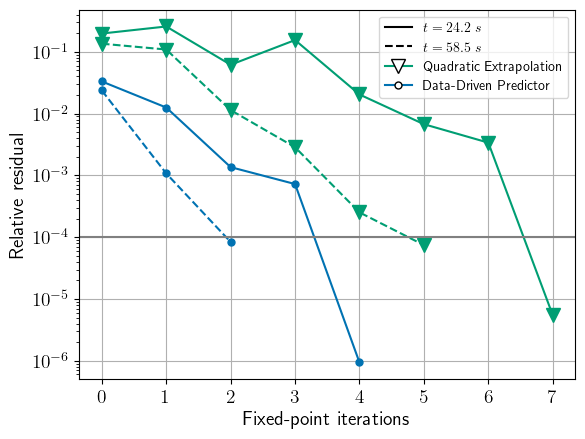

In [14]:
old = np.load("./results/ROM_mu2_QuadPrediction/iters.npy")
new = np.load("./results/ROM_mu2_SurrPrediction/iters.npy")
min_= min(len(old), len(new))

line_cycler   = (cycler(color=["#009E73", "#0072B2", "#009E73", "#0072B2", "#0072B2", "#009E73"]) +
                 cycler(linestyle=["-", "-","--","--","-","--"],
                       marker=["v", ".", "v", ".", "", ""],
                       markevery=[1, 1, 1, 1, 1, 1],markersize = [10, 10, 10, 10, 10, 10]))

fig, ax = plt.subplots()
ax.set_prop_cycle(line_cycler)

increm = 242
#increm = np.random.randint(0, min_)
itersCurrentQuad_1 = old.cumsum()[increm]
itersCurrentQuad_0 = itersCurrentQuad_1 - old[increm]
itersCurrentSurr_1 = new.cumsum()[increm]
itersCurrentSurr_0 = itersCurrentSurr_1 - new[increm]
ax.semilogy(np.load("./results/ROM_mu2_QuadPrediction/rRelNorm.npy")[itersCurrentQuad_0:itersCurrentQuad_1]);
ax.semilogy(np.load("./results/ROM_mu2_SurrPrediction/rRelNorm.npy")[itersCurrentSurr_0:itersCurrentSurr_1]);


increm = 585
#increm = np.random.randint(0, min_)
itersCurrentQuad_1 = old.cumsum()[increm]
itersCurrentQuad_0 = itersCurrentQuad_1 - old[increm]
itersCurrentSurr_1 = new.cumsum()[increm]
itersCurrentSurr_0 = itersCurrentSurr_1 - new[increm]
ax.semilogy(np.load("./results/ROM_mu2_QuadPrediction/rRelNorm.npy")[itersCurrentQuad_0:itersCurrentQuad_1]);
ax.semilogy(np.load("./results/ROM_mu2_SurrPrediction/rRelNorm.npy")[itersCurrentSurr_0:itersCurrentSurr_1]);

ax.set_xlabel("Fixed-point iterations", fontsize = 14);
ax.set_ylabel("Relative residual", fontsize = 14);

color = np.array([["#E69F00", "#56B4E9"],]*2).transpose()  # Can be other colours than b,g,r
marker0 = ['-', '--']
marker = ['v-', '.-']

# legend
label_column = ['Quadratic Extrapolation','Data-Driven Predictor']
label_row = [r'$t=24.2~s$', r'$t=58.5~s$']
rows = [plt.plot([], [], marker0[i], color='k')[0] for i in range(2)]
columns = [plt.plot([], [], marker[i], markerfacecolor='w',
                    markeredgecolor='k')[0] for i in range(2)]

plt.legend(rows + columns, label_row + label_column, loc='best')
ax.axhline(1e-4, color='grey');

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)

plt.grid();
#plt.savefig("someIterationsCase1.png", bbox_inches = 'tight');

But "How typical are the examples given in the figure above ?".
To answer this question, we can show the distribution of:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- The differences in the number $\Delta{N_{k}^n}$ of iterations at each time step $n$, where $\Delta{N_{k}^n} = N_{k, \text{REF}}^n - N_{k, \text{DD}}$, with $N_{k, \text{REF}}^n$ is the number of iterations-to-convergence with the classical predictors (here comparing the quadratic and constant extrapolations) and $N_{k, \text{DD}}^n$ is the number of iterations-to-convergence using the new data-driven predictor. The occurrence of the $\Delta{N_{k}}^n$ quantities greater than $0$ are indicating a performance gain with the new predictors.
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- he ratios of the initial residuals $\zeta^n$ at each time step $n$, where $\zeta^n = ||\boldsymbol{r}_{\text{REF}}^0||_2^n \;/\; ||\boldsymbol{r}_{\text{DD}}^0||_2^n$. The occurrence of the $\zeta^n$ quantities greater than $1$ are indicating a performance gain with the new predictors.    

In [15]:
modelName = 'FOM'
surrIters = np.load("results/"+modelName+"_mu2_SurrPrediction/iters.npy")
surrFirstIterIndices = (surrIters.cumsum() - surrIters)
surrInitialResiduals = np.load("results/"+modelName+"_mu2_SurrPrediction/rNorm.npy")[surrFirstIterIndices]

quadIters = np.load("results/"+modelName+"_mu2_QuadPrediction/iters.npy")
quadFirstIterIndices = (quadIters.cumsum() - quadIters)
quadInitialResiduals = np.load("results/"+modelName+"_mu2_QuadPrediction/rNorm.npy")[quadFirstIterIndices]

Iters = np.load("results/"+modelName+"_mu2/iters.npy")
FirstIterIndices = (Iters.cumsum() - Iters)
InitialResiduals = np.load("results/"+modelName+"_mu2/rNorm.npy")[FirstIterIndices]


differences1 = quadInitialResiduals - surrInitialResiduals
differences2 = quadIters - surrIters
divisions1 = quadInitialResiduals/surrInitialResiduals

differences1ref = InitialResiduals - surrInitialResiduals
differences2ref = Iters - surrIters
divisions1ref = InitialResiduals/surrInitialResiduals

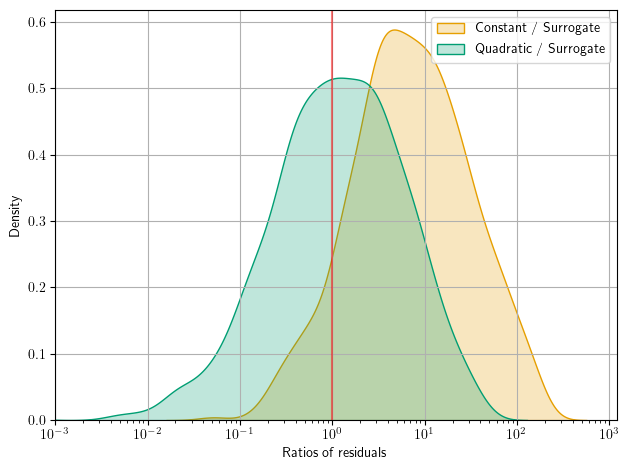

In [16]:
fig, ax = plt.subplots();

plot_data = reject_outliers(divisions1ref, m=4)
seaborn.kdeplot(data=plot_data,
            fill=True, bw_adjust=1., gridsize=2000,
                log_scale=True, color="#E69F00",label=r'Constant $/$ Surrogate'
               );

plot_data = {'Quadratic $/$ Surrogate': reject_outliers(divisions1, m=4)}
seaborn.kdeplot(data=plot_data['Quadratic $/$ Surrogate'], ax = ax,
            fill=True, bw_adjust=1., gridsize=2000,
                log_scale=True, color='#009E73', label=r'Quadratic $/$ Surrogate'
              );
plt.legend();
ax.set(xlabel="Ratios of residuals");
plt.axvline(1, color = 'red', alpha = 0.5);
plt.grid();
plt.xlim(left = 1e-3);
plt.tight_layout();

and we ..

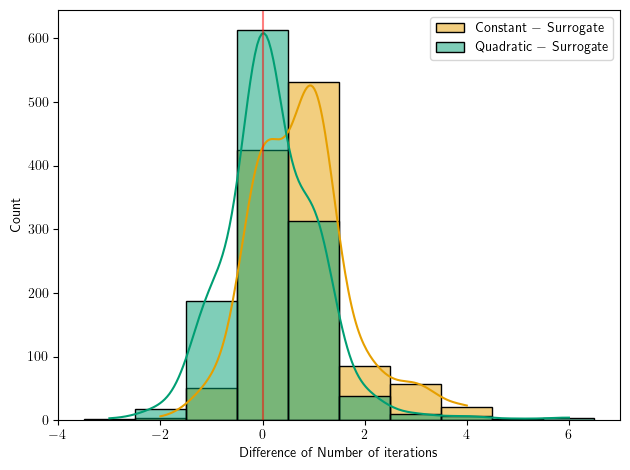

In [17]:
fig, ax = plt.subplots();
plot_data = {'Constant $-$ Surrogate': reject_outliers(differences2ref, m=3), }
g = seaborn.histplot(plot_data['Constant $-$ Surrogate'], discrete=True,
                     label = 'Constant $-$ Surrogate', ax = ax,
                     color='#E69F00', fill = True,
                     kde=True, kde_kws={"bw_adjust":1.85});


plot_data = {'Quadratic $-$ Surrogate': reject_outliers(differences2, m=3), }
h = seaborn.histplot(plot_data['Quadratic $-$ Surrogate'], discrete=True,
                     label = 'Quadratic $-$ Surrogate', ax = ax,
                     color='#009E73', fill = True,
                     kde=True, kde_kws={"bw_adjust":1.85});

ax.set(xlabel='Difference of Number of iterations');
plt.axvline(0, color='red', alpha = 0.5);
plt.legend();
plt.tight_layout();

# References

[1] [Azzeddine Tiba, Thibault Dairay, Florian De Vuyst, Iraj Mortazavi, Juan-Pedro Berro Ramirez (2024). Machine-Learning Enhanced Predictors for Accelerated Convergence of Partitioned Fluid-Structure Interaction Simulations. arXiv preprint arXiv:2405.09941](https://doi.org/10.48550/arXiv.2405.09941)

[2] [Joris Degroote, Peter Bruggeman, Robby Haelterman, Jan Vierendeels,
Stability of a coupling technique for partitioned solvers in FSI applications,
Computers & Structures, Volume 86, Is 23–24, 2008, Pg 2224-2234, ISSN 0045-7949](https://doi.org/10.1016/j.compstruc.2008.05.005)

[3] [Formaggia, L., Nobile, F., Quarteroni, A. (2002). A One Dimensional Model for Blood Flow: Application to Vascular Prosthesis. In: Babuška, I., Ciarlet, P.G., Miyoshi, T. (eds) Mathematical Modeling and Numerical Simulation in Continuum Mechanics. Lecture Notes in Computational Science and Engineering, vol 19. Springer, Berlin, Heidelberg.](https://doi.org/10.1007/978-3-642-56288-4_10)